Мы запустили сплит-тест платежной формы, чтобы проверить следующую гипотезу:
● Если убрать поле для ввода Name on card, то вырастет конверсия в нажатие
кнопки Pay, т.к. пользователям придётся вводит меньше данных.

# Цель
Нужно подсчитать результаты сплит-теста, проанализировать и написать выводы по ним
(какая форма выиграла, на какой из платформ был получен более значимый результат,
что могло повлиять на результат сплит-теста и над чем следует поработать для
оптимизации конверсии).

Название датасета - Dataset_Task1_Solid_Data_Analyst.xlsx

Он содержит:
    ● Уникальный идентификатор посещения - idvisit
    ● Conversion, где 1 - результат успешного нажатия кнопки Pay
    ● Поле A/B, где old - старая форма, new - новая форма без Name on card
    ● Прочие атрибуты
    
Решение должно состоят из 2-х частей: расчеты (Python, iPython Notebook, Excel) и файл
с выводами и графиками.

In [32]:
# установка необх.библиотек
# import sys
!pip3 install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

!pip3 install pandas
!pip3 install xlrd
!pip3 install scipy
!pip3 install statsmodels
!pip3 install matplotlib
!pip3 install seaborn

Requirement already up-to-date: google-api-python-client in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (1.12.3)
Requirement already up-to-date: google-auth-httplib2 in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.0.4)
Requirement already up-to-date: google-auth-oauthlib in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.4.1)
     |████████████████████████████████| 103 kB 581 kB/s eta 0:00:01


In [9]:
# импорты 
import io
from googleapiclient.http import MediaIoBaseDownload
import googleapiclient.discovery
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools

import pandas as pd

In [13]:
# проводим аутентификацию через гугловую апишку

obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('credentials.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

In [28]:
# считываем необходимый файл. Удобно забирать прямо с диска - все изменения на диске тянем сразу 
#  (перезаписываем файл на локальной машине)

DRIVE = googleapiclient.discovery.build(serviceName='drive'
                                        , version='v3'
                                        , http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below

file_id = '16-kZKQIdjeKErkEyPilollVPCj2CHzy1'
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO('solid_split.xlsx', mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100)) 

Download 100%.


# Choosing a sample size

how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
    # Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
    # Alpha value (α) — The critical value we set earlier to 0.05
    # Effect size — How big of a difference we expect there to be between the conversion rates

In [105]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f'We’d need at least {required_n} observations for each group')

We’d need at least 4720 observations for each group


Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [29]:
# путь к исходному файлу с результатами теста
path_to_file = './solid_split.xlsx'

In [82]:
# чтение файла в датафрейм
split = pd.read_excel(path_to_file).fillna('-99')

split.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
10230,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,5830984,MOB
479,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,old,AND,6,360x640,4128527,MOB
719,Other,CHROME,DESKTOP,1,old,WIN,10,1366x768,4428088,WEB


In [95]:
# No action required: Leave the original dataframe untouched and sort the new dataframe
split2 = split.copy()

In [96]:
split2.sample(6)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
13189,Other,CHROME,DESKTOP,0,new,WIN,10,1536x864,4985802,WEB
4702,SAMSUNG,CHROME MOBILE,SMARTPHONE,0,old,AND,8,320x658,4138834,MOB
11623,SAMSUNG,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,5063679,MOB
14096,APPLE,MOBILE SAFARI,SMARTPHONE,0,new,IOS,11.4,375x667,5020533,MOB
26317,Other,CHROME,SMARTPHONE,0,new,AND,4.2,768x1024,6152675,WEB
5829,Other,Other,SMARTPHONE,0,new,AND,5,360x640,5070680,MOB


1) нету даты, за какой период результаты + в какой день получаем буст???
2) хотелось бы проверить по юзеру или по куки файлу не было ли повторных транзакций у форме

In [99]:
# из-за отсутствия id_user сделаю проверку по идентификатору визита
session_counts = split2['idvisit'].value_counts(ascending=False)
multi_visit = session_counts[session_counts > 1].count()

print(f'There are {multi_visit} users that appear multiple times in the dataset')

# окей с отсутствием дублей

There are 0 users that appear multiple times in the dataset


In [85]:
# список измерений для группировки и вычислений
diminsion_col = ['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_resolution', 'platform_v4']

In [86]:
# считаем кол-во визитов в разрезе необходимых измерений
split2['visit_cnt'] = split2.groupby(diminsion_col)['idvisit'].transform('count')


split2 = split2.astype({"visit_cnt": int}, errors='ignore')

split2 = split2.filter(['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_resolution', 'platform_v4', 'visit_cnt'])

split2.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,platform_v4,visit_cnt
26094,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,360x720,MOB,768
1009,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,old,AND,360x640,MOB,108
23582,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,360x640,MOB,3565


In [101]:
# что там по конверсии в разных группах?
pd.crosstab(split2['A/B'], split2['Conversion'], margins=True, margins_name="Total")

Conversion,0,1,Total
A/B,,,
new,13564,1865,15429
old,9806,1350,11156
Total,23370,3215,26585


## Sampling

In [114]:
# random_state=22 для воспроизводимости результатов
control_sample = split2[split2['A/B'] == 'old'].sample(10000)# sample(n=required_n, random_state=22)
test_sample = split2[split2['A/B'] == 'new'].sample(10000)# sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, test_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
2915,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,5,360x640,4102655,MOB
1908,APPLE,MOBILE SAFARI,SMARTPHONE,0,old,IOS,10.3,320x568,4784189,MOB
6157,SAMSUNG,CHROME MOBILE,PHABLET,0,old,AND,6,360x640,4403273,MOB


## Visualising the results

In [115]:
conversion_rates = ab_test.groupby('A/B')['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
A/B,,,
new,0.118,0.322,0.003
old,0.122,0.327,0.003


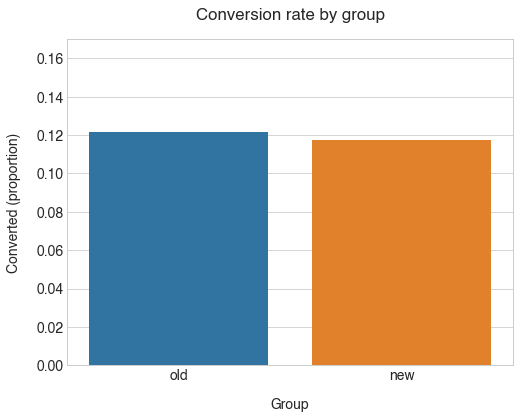

In [116]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['A/B'], y=ab_test['Conversion'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## Segment Summary

In [45]:
# List of names of unique names of the segments
brows_list = list(split2['BROWSERS'].unique())
dev_br_list = list(split2['DEVICES_BRANDS'].unique())
dev_type_list = list(split2['DEVICE_TYPE'].unique())
platf_list = list(split2['platform_v4'].unique())

In [48]:
# Count of the number of segments (or total test variations)
variations_brows = len(brows_list)
variations_dev_brand = len(dev_br_list)
variations_dev_type = len(dev_type_list)
variations_platf = len(platf_list)

# Verify that the segments/categories are correct 
print('Different brow: ',brows_list, 'Number of segments: ', variations_brows)
print('Different dev brand: ',dev_br_list, 'Number of segments: ', variations_dev_brand)
print('Different device type: ',dev_type_list, 'Number of segments: ', variations_dev_type)
print('Different version platform: ',platf_list, 'Number of segments: ', variations_platf)

Different brow:  ['CHROME MOBILE', 'Other', 'MOBILE SAFARI', 'CHROME', 'FIREFOX'] Number of segments:  5
Different dev brand:  ['Other', 'SAMSUNG', 'APPLE', 'HUAWEI'] Number of segments:  4
Different device type:  ['SMARTPHONE', nan, 'PHABLET', 'DESKTOP', 'TABLET', 'PORTABLE_MEDIA_PAYER'] Number of segments:  6
Different version platform:  ['MOB', 'WEB'] Number of segments:  2


в разрезе формы A/B (old, new) - conv=1
в разрезе платформ
